# Census forecasts using Orbit 

This notebook walks through the exercise of fitting an orbit model - Damped Linear Trend Bayesian probabilistic model
on the census data provided at https://www.census.gov/construction/nrc/historical_data/index.html

Orbit is a Python package for Bayesian forecasting models developed under object-oriented design. It provides a familiar and intuitive initialize-fit-predict interface for working with time series tasks, while utilizing probabilistic modeling api under the hood.
For more info : https://github.com/uber/orbit , including installation instructions. First one will need to install PyStan , a library to leverage Stan for Bayesian stats @ https://pystan.readthedocs.io/en/latest/windows.html

### Install necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from orbit.utils.dataset import load_iclaims

### Load the data

In [3]:
permits_raw = pd.read_excel('data/permits_cust.xls',sheet_name='PermitsUA', usecols = 'B:N',skiprows=9,header=None,nrows=743,
                           na_values='(NA)',parse_dates=[0])
permits_raw.columns = ['date','total','total_1unit','total_2to4units','total_5+units','ne_total','ne_1unit',
                      'mw_total','mw_1unit','south_total','south_1unit','west_total','west_1unit']

### Exploratory Data Analysis

In [4]:
permits_raw.tail()

,date,total,total_1unit,total_2to4units,total_5+units,ne_total,ne_1unit,mw_total,mw_1unit,south_total,south_1unit,west_total,west_1unit
738,2020-07-01,135.4,92.1,4.2,39.1,12.7,5.7,21.3,13.4,68.7,51.4,32.6,21.6
739,2020-08-01,126.2,89.9,4.6,31.7,9.9,5.2,17.6,12.6,68.4,51.1,30.3,21.0
740,2020-09-01,133.3,94.7,3.9,34.7,13.2,6.4,19.9,14.0,69.0,52.0,31.2,22.3
741,2020-10-01,132.9,95.3,5.2,32.5,11.5,5.5,21.1,13.8,68.7,53.5,31.7,22.6
742,2020-11-01,120.2,80.0,4.1,36.2,12.2,5.2,16.6,10.3,61.5,45.4,29.9,19.1


In [5]:
permits_raw.head()

,date,total,total_1unit,total_2to4units,total_5+units,ne_total,ne_1unit,mw_total,mw_1unit,south_total,south_1unit,west_total,west_1unit
0,1959-01-01,75.7,55.7,5.2,14.8,11.4,NaN,11.8,NaN,26.8,NaN,25.6,NaN
1,1959-02-01,79.0,59.9,5.2,13.9,13.2,NaN,12.7,NaN,29.4,NaN,23.8,NaN
2,1959-03-01,119.0,91.3,8.4,19.3,22.4,NaN,25.9,NaN,34.8,NaN,35.8,NaN
3,1959-04-01,127.9,99.7,8.0,20.2,23.4,NaN,34.7,NaN,36.0,NaN,33.8,NaN
4,1959-05-01,120.8,93.5,7.5,19.7,23.0,NaN,30.0,NaN,32.3,NaN,35.4,NaN


In [6]:
permits_raw.dtypes

date               datetime64[ns]
total                     float64
total_1unit               float64
total_2to4units           float64
total_5+units             float64
ne_total                  float64
ne_1unit                  float64
mw_total                  float64
mw_1unit                  float64
south_total               float64
south_1unit               float64
west_total                float64
west_1unit                float64
dtype: object

In [7]:
permits_raw.shape

(743, 13)

In [8]:
permits_raw.describe()

,total,total_1unit,total_2to4units,total_5+units,ne_total,ne_1unit,mw_total,mw_1unit,south_total,south_1unit,west_total,west_1unit
count,743.000000,743.000000,743.000000,743.000000,743.000000,611.000000,743.000000,611.000000,743.000000,611.000000,743.000000,611.000000
mean,112.887483,73.926514,6.233109,32.729879,14.458546,8.535516,21.701615,14.428151,47.591655,34.672340,29.137147,19.438298
std,35.565104,26.738809,2.972394,15.547872,6.165800,3.986617,9.039670,6.948263,16.818737,12.472083,10.204002,7.735698
min,36.300000,22.100000,1.100000,7.500000,3.000000,1.700000,2.500000,1.400000,16.500000,10.900000,6.900000,4.100000
25%,89.650000,55.200000,3.900000,23.250000,10.200000,5.000000,14.400000,8.650000,34.700000,25.850000,22.200000,13.750000
50%,111.000000,69.700000,6.000000,30.500000,13.200000,8.400000,21.300000,13.300000,45.800000,33.500000,28.500000,18.900000
75%,135.700000,90.850000,7.800000,39.100000,18.400000,11.100000,28.500000,20.000000,59.050000,41.600000,35.750000,24.250000
max,214.600000,166.200000,16.100000,103.500000,33.700000,22.400000,47.400000,31.700000,101.600000,79.700000,74.700000,45.600000


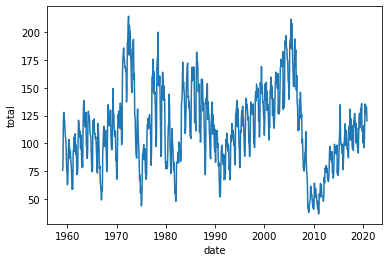

In [9]:
sns.lineplot(x='date',y='total',data=permits_raw);

### Orbit

#### Train and test sets , use the last 3 years to test the model

In [10]:
test_size = 36

In [11]:
train_df = permits_raw[:-test_size]
test_df = permits_raw[-test_size:]

### Damped-Local-Trend (DLT) Model with FULL Bayesian Prediction

We instantiate a dlt model and fit it to the train data (all permit history except the last 3 years)

In [12]:
from orbit.models.dlt import DLTFull
from orbit.diagnostics.plot import plot_predicted_data

no display found. Using non-interactive Agg backend


In [13]:
dlt = DLTFull(
    response_col='total',
    date_col='date',
    #regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=12,
    seed=2020,
    global_trend_option = 'loglinear'
)
dlt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Now we generate predictions on the test data (the last 3 years)

C:\Users\PabloT\AppData\Roaming\Python\Python37\site-packages\orbit\diagnostics\plot.py:114: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


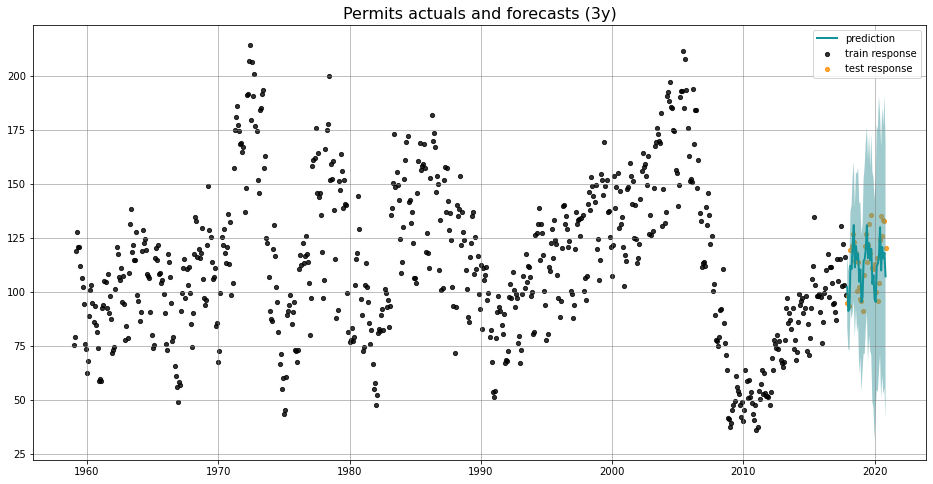

In [14]:
# predicted df
predicted_df = dlt.predict(df=test_df)

# plot predictions
plot_predicted_data(
    training_actual_df=train_df, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=test_df,title='Permits actuals and forecasts (3y)',
);

In [15]:
help(plot_predicted_data)

Help on function plot_predicted_data in module orbit.diagnostics.plot:

plot_predicted_data(training_actual_df, predicted_df, date_col, actual_col, pred_col='prediction', prediction_percentiles=None, title='', test_actual_df=None, is_visible=True, figsize=None, path=None)
    plot training actual response together with predicted data; if actual response of predicted
    data is there, plot it too.
    Parameters
    ----------
    training_actual_df: pd.DataFrame
        training actual response data frame. two columns required: actual_col and date_col
    predicted_df: pd.DataFrame
        predicted data response data frame. two columns required: actual_col and pred_col. If
        user provide prediction_percentiles, it needs to include them as well in such
        `prediction_{x}` where x is the correspodent percentiles
    prediction_percentiles: list
        list of two elements indicates the lower and upper percentiles
    date_col: str
        the date column name
    actual_col

In [16]:
predicted_df.tail()

,date,prediction_5,prediction,prediction_95
31,2020-07-01,50.390395,110.019099,167.345482
32,2020-08-01,61.306325,120.894453,185.598219
33,2020-09-01,52.619422,115.601724,177.263727
34,2020-10-01,55.701272,118.141886,191.009949
35,2020-11-01,41.039118,107.267694,169.934134


In [17]:
test_df.tail()

,date,total,total_1unit,total_2to4units,total_5+units,ne_total,ne_1unit,mw_total,mw_1unit,south_total,south_1unit,west_total,west_1unit
738,2020-07-01,135.4,92.1,4.2,39.1,12.7,5.7,21.3,13.4,68.7,51.4,32.6,21.6
739,2020-08-01,126.2,89.9,4.6,31.7,9.9,5.2,17.6,12.6,68.4,51.1,30.3,21.0
740,2020-09-01,133.3,94.7,3.9,34.7,13.2,6.4,19.9,14.0,69.0,52.0,31.2,22.3
741,2020-10-01,132.9,95.3,5.2,32.5,11.5,5.5,21.1,13.8,68.7,53.5,31.7,22.6
742,2020-11-01,120.2,80.0,4.1,36.2,12.2,5.2,16.6,10.3,61.5,45.4,29.9,19.1


### Hold out Accuracy

Let's calculate the accuracy of the model in the test data (holdout = we didn't show it to the model , we created predictions)

In [18]:
results = pd.merge(predicted_df.iloc[24:36,:],test_df[['date','total']].iloc[24:36,:],how='inner',on='date')
results

,date,prediction_5,prediction,prediction_95,total
0,2019-12-01,46.459756,107.751518,152.981795,110.7
1,2020-01-01,31.468642,96.993852,142.809571,112.8
2,2020-02-01,45.114019,95.391894,152.903603,100.2
3,2020-03-01,54.703366,111.999007,177.372880,115.9
4,2020-04-01,53.893273,113.145608,175.027326,96.0
5,2020-05-01,62.893972,116.763768,190.877435,104.4
6,2020-06-01,71.125995,130.041442,182.669709,124.0
7,2020-07-01,50.390395,110.019099,167.345482,135.4
8,2020-08-01,61.306325,120.894453,185.598219,126.2
9,2020-09-01,52.619422,115.601724,177.263727,133.3


In [19]:
results['abs_error'] = abs(results['total']-results['prediction'])
results.tail()

,date,prediction_5,prediction,prediction_95,total,abs_error
7,2020-07-01,50.390395,110.019099,167.345482,135.4,25.380901
8,2020-08-01,61.306325,120.894453,185.598219,126.2,5.305547
9,2020-09-01,52.619422,115.601724,177.263727,133.3,17.698276
10,2020-10-01,55.701272,118.141886,191.009949,132.9,14.758114
11,2020-11-01,41.039118,107.267694,169.934134,120.2,12.932306


In [20]:
smape = 2*sum(results['abs_error'])/(sum(results['total'])+sum(results['prediction']))
accuracy = max(0,1-smape)

In [21]:
smape,accuracy*100

(0.10093547730155399, 89.9064522698446)

Accuracy of ~90% in 12 months (each month is an error) is not bad at all

Now that we are comfortable with the accuracy of the model we fit a model to the entire permits data

In [22]:
dlt_final = DLTFull(
    response_col='total',
    date_col='date',
    #regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=12,
    global_trend_option = 'loglinear'
)
dlt_final.fit(df=permits_raw[['date','total']])

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In order to forecast into the future I need a data set of future dates

In [23]:
future_df = pd.DataFrame(data= pd.date_range('2020-12-01','2022-01-01',freq='MS'),columns=['date'])

In [24]:
# predicted future
predicted_df_final = dlt_final.predict(df=future_df)
predicted_df_final.tail()

,date,prediction_5,prediction,prediction_95
9,2021-09-01,100.870574,130.200852,164.260011
10,2021-10-01,102.066145,138.582265,172.746540
11,2021-11-01,83.505694,122.170990,158.886812
12,2021-12-01,82.821620,116.866721,153.472812
13,2022-01-01,73.264279,120.763965,153.317973


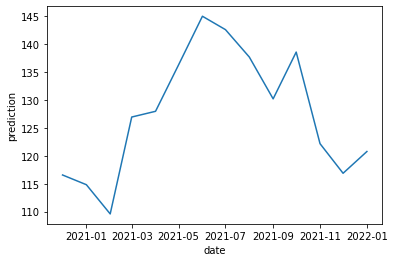

In [25]:
sns.lineplot(x='date',y='prediction',data=predicted_df_final);

## Final table 

Here I create a final data set with the actuals and the forecasts

In [26]:
predicted_df_final['series'] = 'forecast'
predicted_df_final['total'] = predicted_df_final['prediction']
permits_raw['series'] = 'actuals'
permits_total = permits_raw[['date','total','series']].append(predicted_df_final[['date','total','series']])
permits_total.head()

,date,total,series
0,1959-01-01,75.7,actuals
1,1959-02-01,79.0,actuals
2,1959-03-01,119.0,actuals
3,1959-04-01,127.9,actuals
4,1959-05-01,120.8,actuals


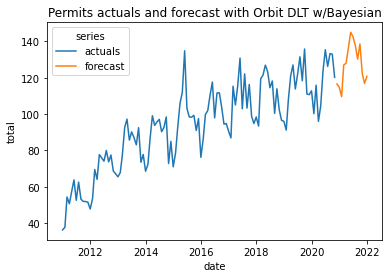

In [27]:
sns.lineplot(x='date',y='total',hue='series',data=permits_total.query('date > "2010-12-01"'))
plt.title('Permits actuals and forecast with Orbit DLT w/Bayesian');

### Write to csv

In [28]:
#permits_total.to_csv('results/permits_act_fct_orbit_dlt.csv',index=False)